In [2]:
from astropy.table import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binned_statistic
from tqdm import tqdm
import astropy.units as u
from astropy.coordinates import SkyCoord, search_around_sky

import matplotlib
plt.rc('font', family='serif'), plt.rc('xtick', labelsize=21), plt.rc('ytick', labelsize=21)
plt.rcParams['savefig.dpi'] = 300
plt.rc('text',usetex=True)
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
np.set_printoptions(precision=3)

In [3]:
def percentile_16(arr):
    return np.percentile(arr,16)

def percentile_84(arr):
    return np.percentile(arr,84)

In [8]:
cat = Table.read('/Volumes/LejaySSD/phosphorus_catalogs/p_cats_v211221/COSMOS_pcat211221_mags_gals_CH1_CH2.fits')

In [16]:
cat = cat[cat['i']<26]
cat = cat[cat['inside_u']==True]

cat = cat[cat['i']>0]
cat = cat[cat['HSC_i_MAG_AUTO']>0]
cat = cat[cat['MAG_AUTO_CH1']>0]
cat = cat[cat['MAG_AUTO_CH2']>0]
cat = cat[cat['IRAC_CH1_MAG']>0]
cat = cat[cat['IRAC_CH2_MAG']>0]

cat = cat[cat['i']<90]
cat = cat[cat['HSC_i_MAG_AUTO']<90]
cat = cat[cat['MAG_AUTO_CH1']<90]
cat = cat[cat['IRAC_CH1_MAG']<90]
cat = cat[cat['MAG_AUTO_CH2']<90]
cat = cat[cat['IRAC_CH2_MAG']<90]
print(len(cat))

88992


In [17]:
# avoid source confusion

print('select only isolated galaxies (5 arcsec separation, 1mag difference)')
print('before',len(cat))

coords = SkyCoord(np.array(cat['RA']) * u.deg, np.array(cat['DEC']) * u.deg)
arr = search_around_sky(coords, coords, 10 / 3600 * u.deg)
sep2d, b = np.unique(np.round(arr[2], 10), return_index=True)  # only keep the unique pairs
arr0 = arr[0][b]
arr1 = arr[1][b]
gal1_list = arr0[sep2d.value > 0.01 / 3600]
gal2_list = arr1[sep2d.value > 0.01 / 3600]

remove_ids = []
for i in range(len(gal1_list)):
    if abs(cat[gal1_list[i]]['HSC_i_MAG_AUTO'] - cat[gal2_list[i]]['HSC_i_MAG_AUTO'])<1:
        remove_ids.append(gal1_list[i])
        remove_ids.append(gal2_list[i])

cat.remove_rows(remove_ids)
print('after',len(cat))

select only isolated galaxies (5 arcsec separation, 1mag difference)
before 88992
after 88992


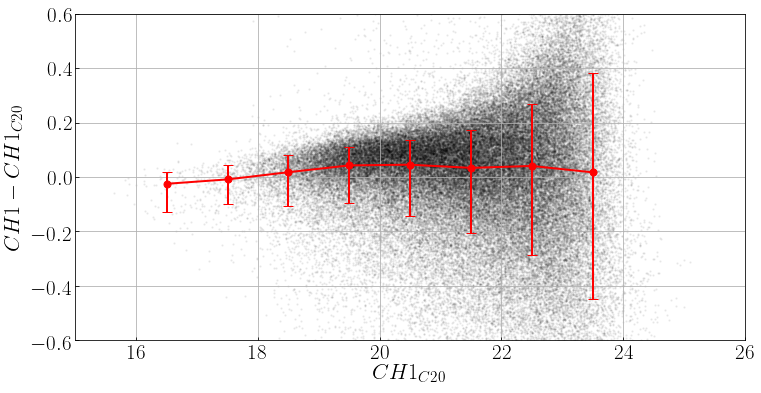

In [14]:
color_diff =  cat['MAG_AUTO_CH1']-cat['IRAC_CH1_MAG']
ch1_medians_ch1,ch1_bin_edgesch1_,bin_numbers = binned_statistic(cat['IRAC_CH1_MAG'], color_diff, statistic='median', bins=np.arange(16,24.5,1))
ch1_per16_ch1,ch1_bin_edges,ch1_bin_numbers = binned_statistic(cat['IRAC_CH1_MAG'], color_diff, statistic=percentile_16, bins=np.arange(16,24.5,1))
ch1_per84_ch1,ch1_bin_edges,ch1_bin_numbers = binned_statistic(cat['IRAC_CH1_MAG'], color_diff, statistic=percentile_84, bins=np.arange(16,24.5,1))

fig = plt.figure(figsize=(12,6))
plt.scatter(cat['IRAC_CH1_MAG'], color_diff,color='k',s=2, alpha=0.05)
plt.errorbar(ch1_bin_edges[:-1]+0.5, ch1_medians_ch1,yerr=[ch1_medians_ch1-ch1_per16_ch1,ch1_per84_ch1-ch1_medians_ch1],fmt='o-',color='r',linewidth=2,capsize=5,markersize=7)
plt.xlabel('$CH1_{C20}$',fontsize=22)
plt.ylabel('$CH1-CH1_{C20}$',fontsize=22)
plt.xlim([15,26])
plt.ylim([-0.6,0.6])
plt.grid()
plt.show()

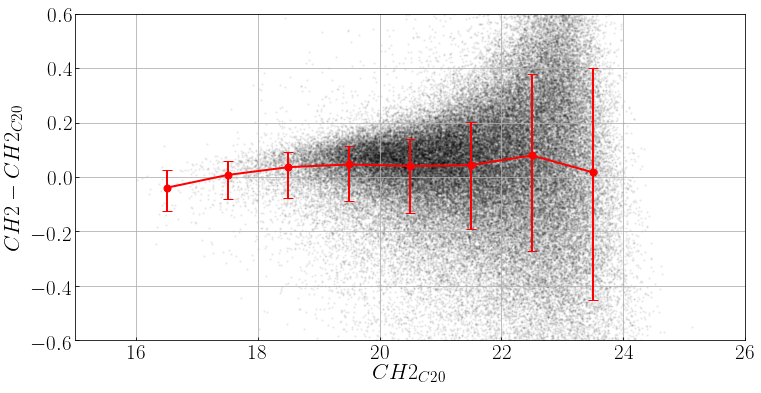

In [15]:
color_diff =  cat['MAG_AUTO_CH2']-cat['IRAC_CH2_MAG']
ch2_medians_ch2,ch2_bin_edges,ch2_bin_numbers = binned_statistic(cat['IRAC_CH2_MAG'], color_diff, statistic='median', bins=np.arange(16,24.5,1))
ch2_per16_ch2,bin_edges,ch2_bin_numbers = binned_statistic(cat['IRAC_CH2_MAG'], color_diff, statistic=percentile_16, bins=np.arange(16,24.5,1))
ch2_per84_ch2,bin_edges,ch2_bin_numbers = binned_statistic(cat['IRAC_CH2_MAG'], color_diff, statistic=percentile_84, bins=np.arange(16,24.5,1))

fig = plt.figure(figsize=(12,6))
plt.scatter(cat['IRAC_CH2_MAG'], color_diff,color='k',s=2, alpha=0.05)
plt.errorbar(ch2_bin_edges[:-1]+0.5,ch2_medians_ch2,yerr=[ch2_medians_ch2-ch2_per16_ch2,ch2_per84_ch2-ch2_medians_ch2],fmt='o-',color='r',linewidth=2,capsize=5,markersize=7)
plt.xlabel('$CH2_{C20}$',fontsize=22)
plt.ylabel('$CH2-CH2_{C20}$',fontsize=22)
plt.xlim([15,26])
plt.ylim([-0.6,0.6])
plt.grid()
plt.show()

In [22]:
for cat_name in ['COSMOS_deep','ELAIS_deep','DEEP_deep']:
    cat=Table.read('/Volumes/LejaySSD/phosphorus_catalogs/p_cats_v211221/'+cat_name.replace('_deep','')+'_pcat211221_mags_gals_CH1_CH2.fits')
    ch1_corr_list=[]
    ch2_corr_list=[]
    ch1_cali_err_list=[]
    ch2_cali_err_list=[]
    ch1_corr_err_list=[]
    ch2_corr_err_list=[]

    non_detect = 0
    for gal in tqdm(cat):
    
        # ch1
        if gal['MAG_AUTO_CH1']>-99:
            ch1_corr = gal['MAG_AUTO_CH1'] - np.interp(gal['MAG_AUTO_CH1'],bin_edges[:-1]+0.5,ch1_medians_ch1)
            ch1_phot_err = gal['MAGERR_AUTO_CH1']
            ch1_calib_err = (np.interp(gal['MAG_AUTO_CH1'],ch1_bin_edges[:-1]+0.5,ch1_per84_ch1) - np.interp(gal['MAG_AUTO_CH1'],ch1_bin_edges[:-1]+0.5,ch1_per16_ch1))/2
            ch1_corr_err = np.sqrt(ch1_phot_err**2 + ch1_calib_err**2)
            
            ch1_corr_list.append(ch1_corr)
            ch1_cali_err_list.append(ch1_calib_err)
            ch1_corr_err_list.append(ch1_corr_err)
        else:
            non_detect += 1
            ch1_corr_list.append(-99)
            ch1_cali_err_list.append(99)
            ch1_corr_err_list.append(99)
        
        # ch2
        if gal['MAG_AUTO_CH2']>-99:
            ch2_corr = gal['MAG_AUTO_CH2'] - np.interp(gal['MAG_AUTO_CH2'],bin_edges[:-1]+0.5,ch2_medians_ch2)
            ch2_phot_err = gal['MAGERR_AUTO_CH2']
            ch2_calib_err = (np.interp(gal['MAG_AUTO_CH2'],ch2_bin_edges[:-1]+0.5,ch2_per84_ch2) - np.interp(gal['MAG_AUTO_CH2'],ch2_bin_edges[:-1]+0.5,ch2_per16_ch2))/2
            ch2_corr_err = np.sqrt(ch2_phot_err**2 + ch2_calib_err**2)
            
            ch2_corr_list.append(ch2_corr)
            ch2_cali_err_list.append(ch2_calib_err)
            ch2_corr_err_list.append(ch2_corr_err)
        else:   
            ch2_corr_list.append(-99)
            ch2_cali_err_list.append(99)
            ch2_corr_err_list.append(99)
    
    print(non_detect)
    print(len(cat))
    
    ch1_corr_col = Column(name='MAG_AUTO_CH1_CORR', data=np.array(ch1_corr_list))
    ch2_corr_col = Column(name='MAG_AUTO_CH2_CORR', data=np.array(ch2_corr_list))
    ch1_cali_err_col = Column(name='MAGERR_AUTO_CH1_CALI', data=np.array(ch1_cali_err_list))
    ch2_cali_err_col = Column(name='MAGERR_AUTO_CH2_CALI', data=np.array(ch2_cali_err_list))
    ch1_corr_err_col = Column(name='MAGERR_AUTO_CH1_CORR', data=np.array(ch1_corr_err_list))
    ch2_corr_err_col = Column(name='MAGERR_AUTO_CH2_CORR', data=np.array(ch2_corr_err_list))
    cat.add_columns([ch1_corr_col,ch2_corr_col,ch1_cali_err_col,ch2_cali_err_col,ch1_corr_err_col,ch2_corr_err_col])
    
    cat.write('/Volumes/LejaySSD/'+cat_name+'_pcat211221_mags_gals_CH1_CH2_corr.fits', overwrite=True)

100%|██████████| 5153248/5153248 [10:09<00:00, 8458.78it/s] 


4683384
5153248


100%|██████████| 3555124/3555124 [01:14<00:00, 47776.25it/s] 


2978353
3555124


100%|██████████| 3336219/3336219 [00:51<00:00, 65143.19it/s] 


2997441
3336219
